# Lab 1 Checkpoint 1

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nudratabbas/vitamin-deficiency-disease-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vitamin-deficiency-disease-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/vitamin-deficiency-disease-prediction-dataset


In [ ]:
import pandas

## Dataset Summary

### Motivation
The goal of this project is to build a machine learning model that can distinguish between *healthy* and *not healthy* individuals based on demographic, behavioral, and symptom-related features. Early identification of potential disease risk can support preventive care and more efficient clinical decision-making.

### Target Definition
The target variable is **`disease_diagnosis`**, which is converted into a binary label:
- **Healthy** -> `False`
- **Not Healthy (any non-healthy diagnosis)** -> `True`

This switch turns the task into a binary classification problem focused on detecting the presence of disease rather than predicting specific conditions.

### Data Source and License / Terms
The dataset is sourced from a publicly available health-related dataset. The data is assumed to be **de-identified** and used in accordance with its stated license or terms of use (e.g., non-commercial, academic use). No personally identifiable information (PII) is included. https://www.kaggle.com/datasets/nudratabbas/vitamin-deficiency-disease-prediction-dataset

### Feature Dictionary (Selected Features)
- **Age** *(numeric)*: Age of the individual.
- **BMI / weight-related measures** *(numeric)*: Indicators of body composition.
- **Alcohol consumption** *(categorical, includes intentional `None`)*: Self-reported alcohol usage category.
- **Symptoms list** *(categorical, includes intentional `None`)*: Reported symptoms or absence of symptoms.
- **Lifestyle indicators** *(categorical / boolean)*: Features related to habits or behaviors.
  
Numeric features are standardized, while categorical features are one-hot encoded. Intentional `None` values are preserved as explicit categories rather than treated as missing data.

### Known Limitations and Risks
- **Class imbalance** may affect model performance. (60-40 split)
- **Self-reported features** (e.g., symptoms, alcohol use) may introduce reporting bias
- **Potential proxy bias**: Certain features may indirectly encode socioeconomic or demographic information
- **Limited generalizability**: The dataset may not represent all populations or clinical settings



# Task
Get the dataset in the dataset directory `'/kaggle/input/vitamin-deficiency-disease-prediction-dataset'` to identify the main dataset file. We load this dataset into a DataFrame, preprocess/encode if need be, and then train a baseline kNN model and evaluate its performance.

In [ ]:
import os

# List the contents of the dataset directory
file_list = os.listdir(path)

# Print the list of files
print("Files in the dataset directory:", file_list)

Files in the dataset directory: ['vitamin_deficiency_disease_dataset_20260123.csv']


In [ ]:
import pandas as pd

dataset_file_path = os.path.join(path, file_list[0])
df = pd.read_csv(dataset_file_path)

print("Dataset loaded successfully. First 5 rows:")
print(df.head())

Dataset loaded successfully. First 5 rows:
   age  gender   bmi smoking_status alcohol_consumption exercise_level  \
0   79    Male  24.8         Former                 NaN         Active   
1   77  Female  39.9         Former            Moderate          Light   
2   24    Male  26.4         Former               Heavy       Moderate   
3   69    Male  23.1          Never               Heavy       Moderate   
4   63    Male  29.6          Never                 NaN       Moderate   

    diet_type sun_exposure income_level latitude_region  ...  \
0  Vegetarian         High         High             Mid  ...   
1    Omnivore          Low          Low             Low  ...   
2    Omnivore          Low         High            High  ...   
3  Vegetarian         High          Low             Low  ...   
4  Vegetarian     Moderate         High             Low  ...   

   has_night_blindness  has_fatigue  has_bleeding_gums  has_bone_pain  \
0                    0            0                  0

# Task
Perform a data quality audit on the `df` DataFrame including a missingness summary, duplicate rows check, and target variable (`disease_diagnosis`) distribution. Then, investigate the class imbalance in the target variable as a relevant bias consideration.

In [ ]:
print("Data Quality Audit\n")

# 1. Missingness summary
print("1. Missingness Summary (per column):")
missing_summary = df.isnull().sum().to_frame(name="Missing Count")
missing_summary["Missing %"] = (missing_summary["Missing Count"] / len(df)) * 100
print(missing_summary[missing_summary["Missing Count"] > 0])
print("\n" + "-"*50 + "\n")

# 2. Duplicate rows check
num_duplicates = df.duplicated().sum()
print("2. Duplicate Rows Check:")
print(f"Number of duplicate rows: {num_duplicates}")
print("\n" + "-"*50 + "\n")

# 3. Target distribution
print("3. Target Distribution:")
target_col = "disease_diagnosis"

if target_col in df.columns:
    target_distribution = df[target_col].value_counts(normalize=True)
    print(target_distribution)
else:
    print(f"Target column '{target_col}' not found in dataset.")
print("\n" + "-"*50 + "\n")

Data Quality Audit

1. Missingness Summary (per column):
                     Missing Count  Missing %
alcohol_consumption           1278      31.95
symptoms_list                 1328      33.20

--------------------------------------------------

2. Duplicate Rows Check:
Number of duplicate rows: 0

--------------------------------------------------

3. Target Distribution:
disease_diagnosis
Healthy                 0.37725
Anemia                  0.31125
Rickets_Osteomalacia    0.25725
Night_Blindness         0.03050
Scurvy                  0.02375
Name: proportion, dtype: float64

--------------------------------------------------



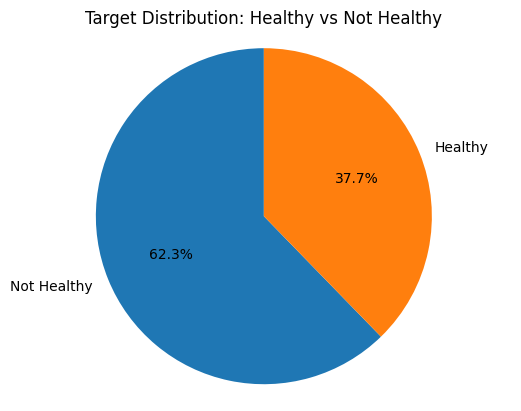

In [ ]:

# pie chart
import matplotlib.pyplot as plt

if target_col in df.columns:
    pie_data = df[target_col].apply(
        lambda x: "Healthy" if x == "Healthy" or x is False else "Not Healthy"
    ).value_counts()

    plt.figure()
    plt.pie(
        pie_data.values,
        labels=pie_data.index,
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Target Distribution: Healthy vs Not Healthy")
    plt.axis("equal")  # Ensures pie is a circle
    plt.show()


# Leakage-risk note

In the dataset, there are no leakage risk. This is becuase the dataset lacks any unique row IDs, timestamp entries, duplicate rows. There are also no post-outcome fields in the dataset. Although, since the provenance of the dataset dictates that it was synthetically generated, this might result in issues with leakage because the rules used to generate the data may be learned rather than the real-life data patterns themselves.

# Preprocessing Stage

Need to impute values for alc consumption and symptoms list because they have None values

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Binary target: True if NOT healthy, False if healthy
y = df["disease_diagnosis"].apply(lambda x: x != "Healthy")
X = df.drop(columns=["disease_diagnosis"])

# Numeric features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Categorical features
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# explicitly ensure intentional None-valued columns are treated as categorical
intentional_none_cols = ["alcohol_consumption", "symptoms_list"]
for col in intentional_none_cols:
    if col in X.columns and col not in categorical_features:
        categorical_features.append(col)
    if col in numeric_features:
        numeric_features.remove(col)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# pipelines
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])

print("Preprocessing pipeline created successfully.")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")


Preprocessing pipeline created successfully.
Numeric features (24): ['age', 'bmi', 'vitamin_a_percent_rda', 'vitamin_c_percent_rda', 'vitamin_d_percent_rda', 'vitamin_e_percent_rda', 'vitamin_b12_percent_rda', 'folate_percent_rda', 'calcium_percent_rda', 'iron_percent_rda', 'hemoglobin_g_dl', 'serum_vitamin_d_ng_ml', 'serum_vitamin_b12_pg_ml', 'serum_folate_ng_ml', 'symptoms_count', 'has_night_blindness', 'has_fatigue', 'has_bleeding_gums', 'has_bone_pain', 'has_muscle_weakness', 'has_numbness_tingling', 'has_memory_problems', 'has_pale_skin', 'has_multiple_deficiencies']
Categorical features (9): ['gender', 'smoking_status', 'alcohol_consumption', 'exercise_level', 'diet_type', 'sun_exposure', 'income_level', 'latitude_region', 'symptoms_list']
Train size: 3200 | Test size: 800


Index(['age', 'gender', 'bmi', 'smoking_status', 'alcohol_consumption',
       'exercise_level', 'diet_type', 'sun_exposure', 'income_level',
       'latitude_region', 'vitamin_a_percent_rda', 'vitamin_c_percent_rda',
       'vitamin_d_percent_rda', 'vitamin_e_percent_rda',
       'vitamin_b12_percent_rda', 'folate_percent_rda', 'calcium_percent_rda',
       'iron_percent_rda', 'hemoglobin_g_dl', 'serum_vitamin_d_ng_ml',
       'serum_vitamin_b12_pg_ml', 'serum_folate_ng_ml', 'symptoms_count',
       'symptoms_list', 'has_night_blindness', 'has_fatigue',
       'has_bleeding_gums', 'has_bone_pain', 'has_muscle_weakness',
       'has_numbness_tingling', 'has_memory_problems', 'has_pale_skin',
       'has_multiple_deficiencies'],
      dtype='object')
=== KNN Test Performance ===
Accuracy: 0.9187
F1 Score: 0.9337


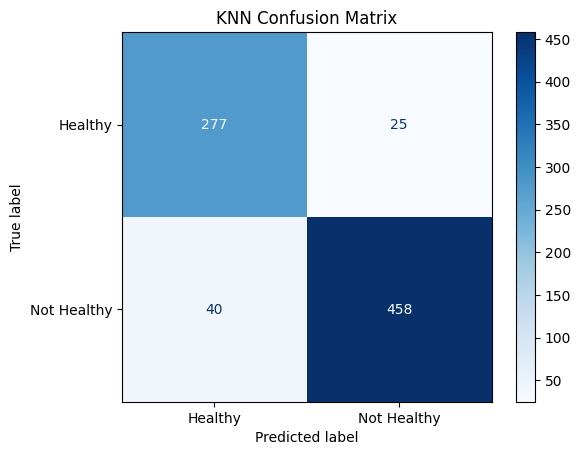

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(X_test.columns)

# kNN training + preprocessing
knn_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier(
        n_neighbors=5,
        weights="distance",
        metric="minkowski"
    ))
])

# training
knn_pipeline.fit(X_train, y_train)

# eval
y_pred = knn_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== KNN Test Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Healthy", "Not Healthy"]
)

disp.plot(cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.show()